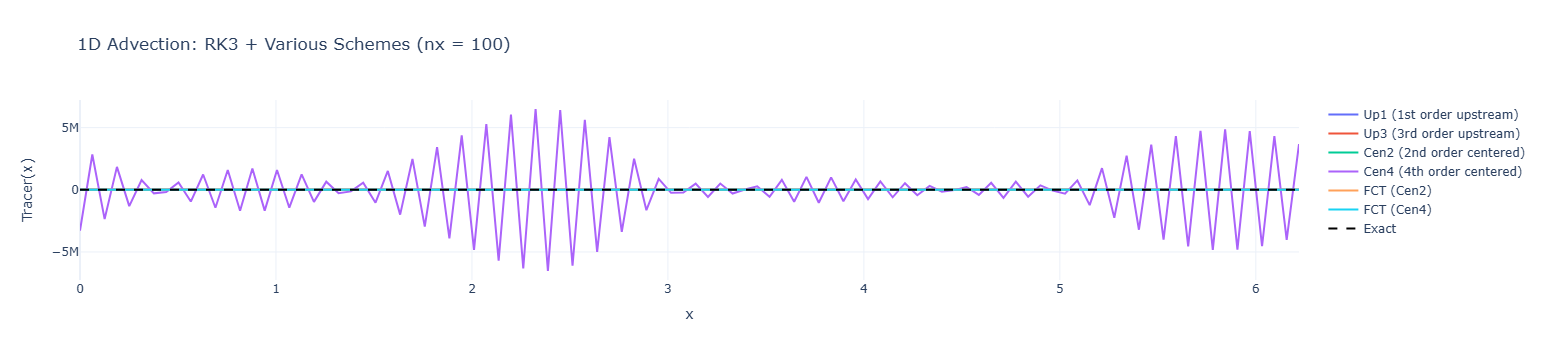

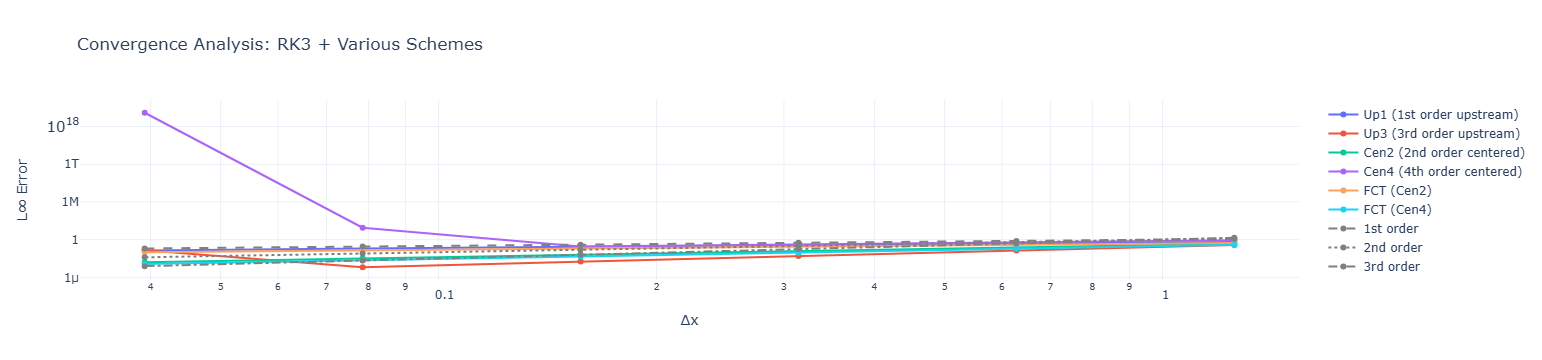

In [12]:
import numpy as np
import plotly.graph_objs as go

# --- Parameters ---
L = 2 * np.pi
time_final = 1
u = 1.0
CFL = 0.1

# --- Initial condition ---
def initial_condition(x):
    return np.sin(x)

# --- Flux functions ---
def compute_flux_up1(T, u, dx):
    T_padded = np.pad(T, (1, 1), mode='wrap')
    flux = np.zeros(len(T) + 1)
    for i in range(len(flux)):
        ip = i + 1
        T_half = T_padded[ip - 1] if u > 0 else T_padded[ip]
        flux[i] = u * T_half
    return flux

def compute_flux_up3(T, u, dx):
    T_padded = np.pad(T, (2, 2), mode='wrap')
    flux = np.zeros(len(T) + 1)
    for i in range(len(flux)):
        ip = i + 2
        if u > 0:
            T_half = (2*T_padded[ip-1] + 5*T_padded[ip] - T_padded[ip+1]) / 6.
        else:
            T_half = (2*T_padded[ip+2] + 5*T_padded[ip+1] - T_padded[ip]) / 6.
        flux[i] = u * T_half
    return flux

def compute_flux_cen2(T, u, dx):
    T_padded = np.pad(T, (1, 1), mode='wrap')
    flux = np.zeros(len(T) + 1)
    for i in range(len(flux)):
        ip = i + 1
        T_half = 0.5 * (T_padded[ip] + T_padded[ip - 1])
        flux[i] = u * T_half
    return flux

def compute_flux_cen4(T, u, dx):
    T_padded = np.pad(T, (2, 2), mode='wrap')
    flux = np.zeros(len(T) + 1)
    for i in range(len(flux)):
        ip = i + 2
        delta_i = T_padded[ip] - T_padded[ip - 1]
        delta_ip1 = T_padded[ip + 1] - T_padded[ip]
        T_half = T_padded[ip] + (delta_i - delta_ip1) / 6.0
        flux[i] = u * T_half
    return flux

def compute_flux_fct(T, u, dx, base='cen4'):
    T_padded = np.pad(T, (1, 1), mode='wrap')
    flux_lo = np.zeros(len(T) + 1)
    for i in range(len(flux_lo)):
        ip = i + 1
        T_half = T_padded[ip - 1] if u > 0 else T_padded[ip]
        flux_lo[i] = u * T_half

    if base == 'cen4':
        flux_ho = compute_flux_cen4(T, u, dx)
    elif base == 'cen2':
        flux_ho = compute_flux_cen2(T, u, dx)
    else:
        raise ValueError("FCT base must be 'cen2' or 'cen4'.")

    theta = 0.5
    return theta * flux_ho + (1 - theta) * flux_lo

# --- RK3 time stepping ---
def rk3_step(T, u, dx, dt, flux_scheme):
    flux_fn = {
        "up1": compute_flux_up1,
        "up3": compute_flux_up3,
        "cen2": compute_flux_cen2,
        "cen4": compute_flux_cen4,
        "fct_cen2": lambda T, u, dx: compute_flux_fct(T, u, dx, base='cen2'),
        "fct_cen4": lambda T, u, dx: compute_flux_fct(T, u, dx, base='cen4'),
    }[flux_scheme]

    F1 = flux_fn(T, u, dx)
    R1 = - (F1[1:] - F1[:-1]) / dx
    T1 = T + dt * R1

    F2 = flux_fn(T1, u, dx)
    R2 = - (F2[1:] - F2[:-1]) / dx
    T2 = 0.75 * T + 0.25 * (T1 + dt * R2)

    F3 = flux_fn(T2, u, dx)
    R3 = - (F3[1:] - F3[:-1]) / dx
    T_new = (1/3) * T + (2/3) * (T2 + dt * R3)

    return T_new

# --- Simulation runner ---
def run_simulation(nx, flux_scheme):
    dx = L / nx
    dt = CFL * dx / u
    nt = int(time_final // dt)

    DOM = np.linspace(0, L, nx, endpoint=False)
    SOL_init = initial_condition(DOM)
    SOL_num = SOL_init.copy()

    for _ in range(nt):
        SOL_num = rk3_step(SOL_num, u, dx, dt, flux_scheme)

    SOL_exact = initial_condition((DOM - u * nt * dt) % L)
    return DOM, SOL_num, SOL_exact, dx, dt, nt

# --- Schemes ---
scheme_list = [
    ("up1", "Up1 (1st order upstream)"),
    ("up3", "Up3 (3rd order upstream)"),
    ("cen2", "Cen2 (2nd order centered)"),
    ("cen4", "Cen4 (4th order centered)"),
    ("fct_cen2", "FCT (Cen2)"),
    ("fct_cen4", "FCT (Cen4)"),
]

# --- Interactive plot: Single solution comparison ---
fig1 = go.Figure()
for scheme_key, scheme_label in scheme_list:
    DOM, SOL_num, SOL_exact, dx, dt, nt = run_simulation(100, scheme_key)
    fig1.add_trace(go.Scatter(x=DOM, y=SOL_num, mode='lines', name=scheme_label))
fig1.add_trace(go.Scatter(x=DOM, y=SOL_exact, mode='lines', name='Exact', line=dict(dash='dash', color='black')))
fig1.update_layout(
    title='1D Advection: RK3 + Various Schemes (nx = 100)',
    xaxis_title='x',
    yaxis_title='Tracer(x)',
    template='plotly_white'
)
fig1.show()

# --- Interactive plot: Convergence analysis ---
fig2 = go.Figure()
for scheme_key, scheme_label in scheme_list:
    DX = []
    ERROR = []
    for nx in [5, 10, 20, 40, 80, 160]:
        DOM, SOL_num, SOL_exact, dx, dt, nt = run_simulation(nx, scheme_key)
        error = np.linalg.norm(SOL_num - SOL_exact, np.inf)
        DX.append(dx)
        ERROR.append(error)
    fig2.add_trace(go.Scatter(x=DX, y=ERROR, mode='lines+markers', name=scheme_label))

# Reference slopes
ref_dx = np.array(DX)
fig2.add_trace(go.Scatter(x=ref_dx, y=ref_dx, name='1st order', line=dict(dash='dash', color='gray')))
fig2.add_trace(go.Scatter(x=ref_dx, y=ref_dx**2, name='2nd order', line=dict(dash='dot', color='gray')))
fig2.add_trace(go.Scatter(x=ref_dx, y=ref_dx**3, name='3rd order', line=dict(dash='dashdot', color='gray')))

fig2.update_layout(
    title='Convergence Analysis: RK3 + Various Schemes',
    xaxis_type='log',
    yaxis_type='log',
    xaxis_title='Δx',
    yaxis_title='L∞ Error',
    template='plotly_white'
)
fig2.show()